In [ ]:
!pip install yfinance backtrade requests_cache matplotx

In [1]:
from __future__ import annotations
from typing import Any, Iterable

from pandas import Series
import pandas as pd
from backtrade import Backtester, CloseData, LimitOrder, MarketOrder, _IndexType
import yfinance as yf
import pandas_ta as ta # flake8: noqa
from requests_cache import CachedSession
import matplotlib.style
import matplotx.styles
matplotlib.style.use(matplotx.styles.dracula)

# Download data
session = CachedSession("yfinance.cache")
df = yf.download("BTC-USD", period="730d", interval="1h", session=session)

[*********************100%***********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'spread',
       'hour'],
      dtype='object')

''

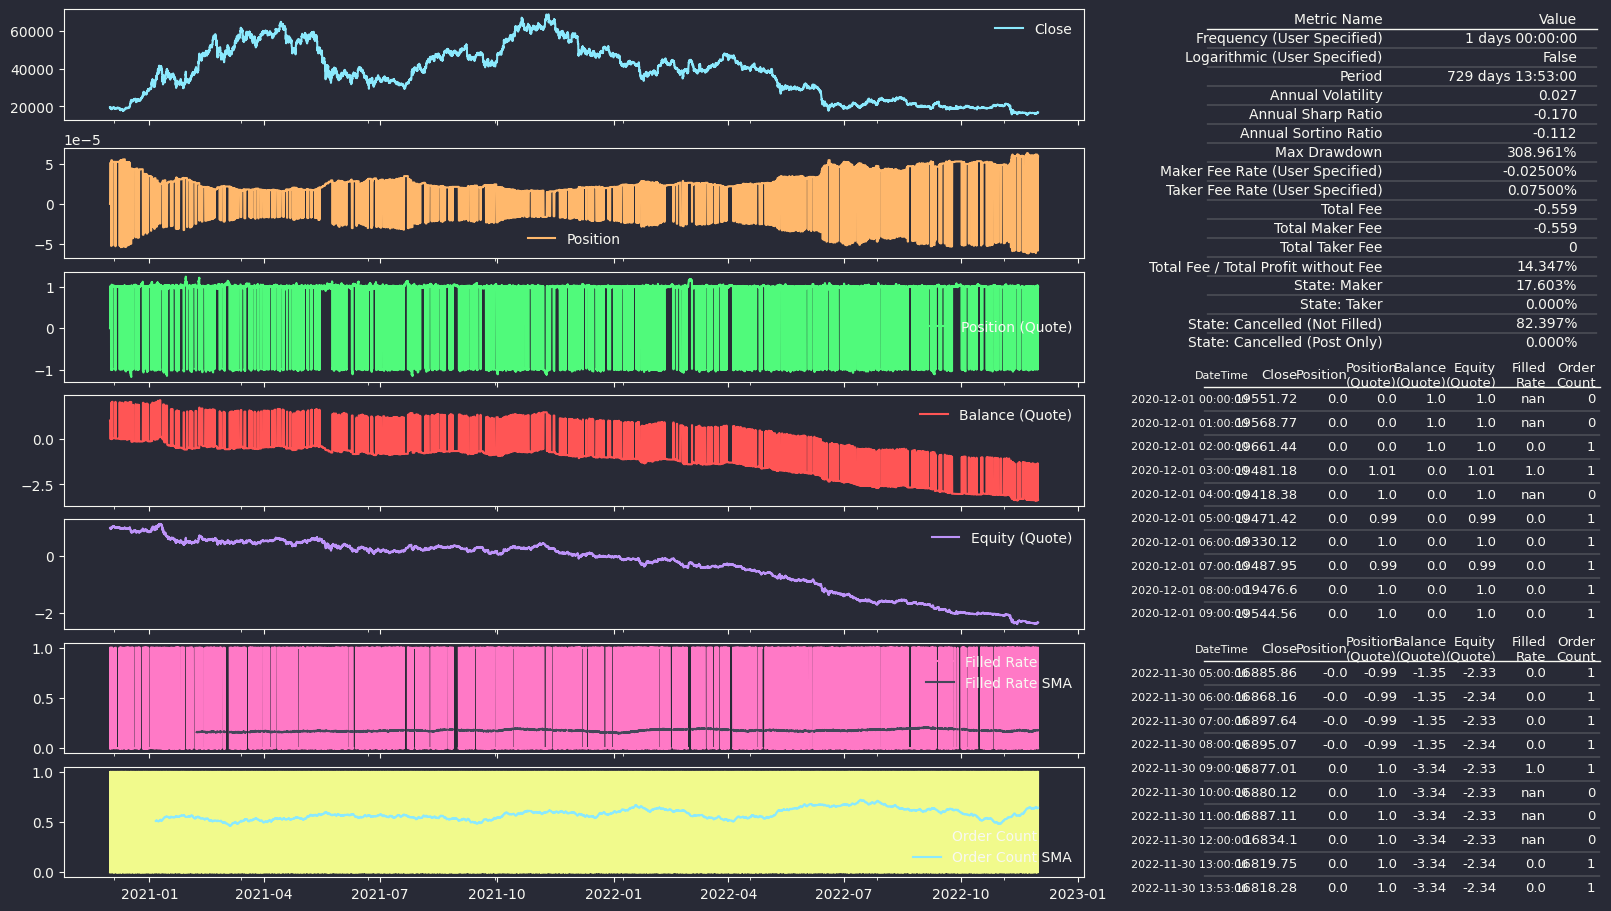

In [2]:
# Define my strategy
class MyBacktest(Backtester):
    def init(self):
        pass

    def on_close(
        self, data: "CloseData[_IndexType]", row: "Series[Any]"
    ) -> Iterable[MarketOrder | LimitOrder]:
        if pd.isna(row["spread"]):
            return
        if data.position_quote < 1 and row["hour"] not in [1,4,12,16,18]:
            buy_price = data.close - row["spread"] * 1.1
            yield LimitOrder(size=(1 - data.position_quote) / buy_price, price = buy_price, post_only=True)
        if data.position_quote > -1 and row["hour"] in [1,4,12,16,18]:
            sell_price = data.close + row["spread"] * 0.9
            yield LimitOrder(size=(-1 - data.position_quote) / sell_price, price = sell_price, post_only=True)

# Calculate indicators
df["spread"] = df.ta.true_range()
df["hour"] = df.index.hour
display(df.columns)

# Run backtest
bt = MyBacktest()
res = bt(df, maker_fee=-0.025 * 0.01, taker_fee=0.075 * 0.01)
res.logarithmic = False
res.plot()

# Avoid showing the plot twice
""
# Finance is not easy...